In [101]:
from catboost import CatBoostRegressor
from datetime import datetime, timedelta
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from matplotlib import pyplot
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pmdarima.arima import auto_arima, ARIMA
from pylab import rcParams
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.wait import WebDriverWait
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from statistics import mean
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from time import sleep
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from xgboost import plot_importance, plot_tree, XGBClassifier
from xgboost.sklearn import XGBClassifier
from IPython.display import clear_output
import datetime as dt
import getpass
import graphviz
import hyperopt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pmdarima as pm
import pycountry
import pycountry_convert as pc
import pydotplus
import pyodbc 
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
import xgboost as xgb
pd.options.display.float_format = '{:.2f}'.format   
pd.plotting.register_matplotlib_converters()
rcParams['figure.figsize'] = 15, 5
warnings.filterwarnings('ignore')

## Data load

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
df = pd.melt(df, id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='Date', value_name='Confirmed')
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.00,65.00,2020-01-22,0
1,NaN,Albania,41.15,20.17,2020-01-22,0
2,NaN,Algeria,28.03,1.66,2020-01-22,0
3,NaN,Andorra,42.51,1.52,2020-01-22,0
4,NaN,Angola,-11.20,17.87,2020-01-22,0


In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28462 entries, 0 to 28461
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  8774 non-null   object        
 1   Country/Region  28462 non-null  object        
 2   Lat             28462 non-null  float64       
 3   Long            28462 non-null  float64       
 4   Date            28462 non-null  datetime64[ns]
 5   Confirmed       28462 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.3+ MB


In [4]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(28462, 6)

In [5]:
df_worldwide = pd.DataFrame(df.groupby('Date')['Confirmed'].sum())
df_worldwide['Date'] = df_worldwide.index
df_worldwide = df_worldwide.reset_index(drop=True)
df_worldwide['Country'] = 'Worldwide'
df = df.append(df_worldwide)

In [6]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [7]:
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country','Lat','Long']).cumcount()+1

In [8]:
df.head()

,Province,Country,Lat,Long,Date,Confirmed,Province_and_country,Days_since_outbreak_global
0,NaN,Afghanistan,33.00,65.00,2020-01-22,0,Afghanistan,1
1,NaN,Albania,41.15,20.17,2020-01-22,0,Albania,1
2,NaN,Algeria,28.03,1.66,2020-01-22,0,Algeria,1
3,NaN,Andorra,42.51,1.52,2020-01-22,0,Andorra,1
4,NaN,Angola,-11.20,17.87,2020-01-22,0,Angola,1


In [9]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [10]:
len(df['Province_and_country'].unique())

267

In [11]:
len(df['Country'].unique())

188

In [12]:
len(df['Province'].unique())

83

In [13]:
df.describe()

,Lat,Long,Confirmed,Days_since_outbreak_global
count,28462.00,28462.00,28569.00,28569.00
mean,21.26,22.43,6914.68,54.00
std,24.70,70.35,97440.58,30.89
min,-51.80,-135.00,0.00,1.00
25%,6.88,-19.02,0.00,27.00
50%,23.49,20.92,11.00,54.00
75%,41.15,78.00,297.00,81.00
max,71.71,178.06,3845718.00,107.00


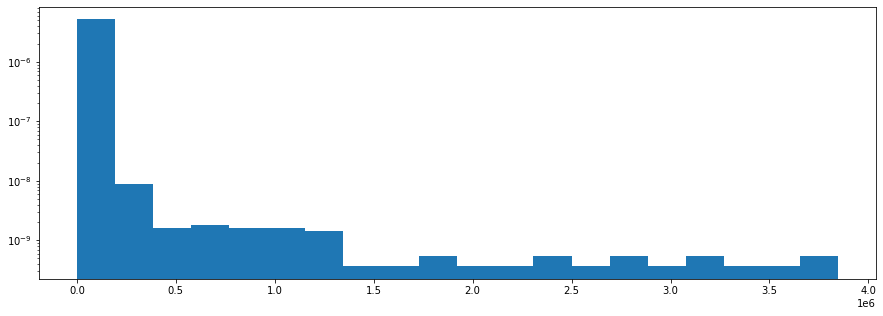

In [14]:
plt.hist(df['Confirmed'], density=True, bins=20) 
plt.yscale('log')

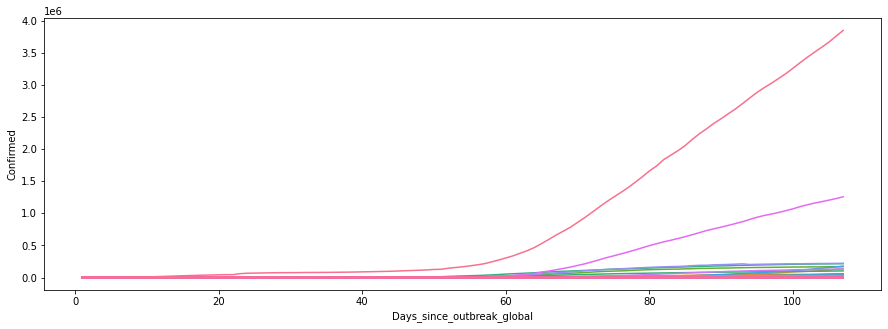

In [15]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Afghanistan                   0    0    0    0    0    0    0    0    0    0   
Albania                       0    0    0    0    0    0    0    0    0    0   
Algeria                       0    0    0    0    0    0    0    0    0    0   
Andorra                       0    0    0    0    0    0    0    0    0    0   
Angola                        0    0    0    0    0    0    0    0    0    0   

Days_since_outbreak_global  ...   98    99    100   101   102   103   104  \
Country                     ...                                             
Afghanistan                 ...  1828  1939  2171  2335  2469  2704  2894   
Albania                     ...   750   766   773   782   789   795   803   
Algeria                     ...  3649  3848  4006  4154  4295  4474  4648   
Andorra                     ...   743   743   745   74

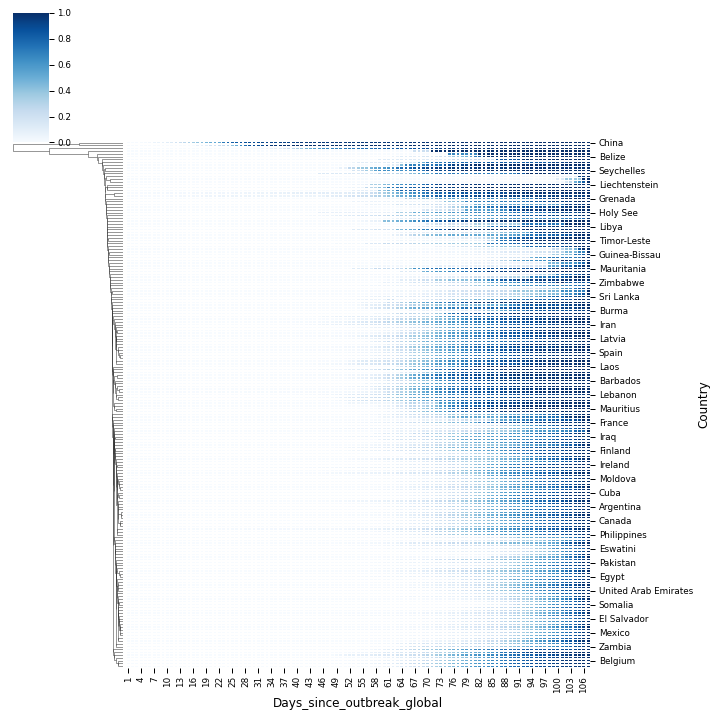

<Figure size 1800x576 with 0 Axes>

In [16]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":12})   
def group_and_chart(Geography, Figure, Data):
    grouped = Data.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped= pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped=grouped.pivot(index='Days_since_outbreak_global', columns=Geography, values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    print(grouped.head())
    sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0,  col_cluster=False, method='single')
    plt.figure(figsize=(25,8))
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

In [17]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
df_country = pd.read_csv(url)
df_country = df_country.drop_duplicates(subset=['Country_Region'], keep=False)
df_country

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.00,nan,NaN,NaN,Afghanistan,33.94,67.71,Afghanistan,38928341.00
1,8,AL,ALB,8.00,nan,NaN,NaN,Albania,41.15,20.17,Albania,2877800.00
2,12,DZ,DZA,12.00,nan,NaN,NaN,Algeria,28.03,1.66,Algeria,43851043.00
3,20,AD,AND,20.00,nan,NaN,NaN,Andorra,42.51,1.52,Andorra,77265.00
4,24,AO,AGO,24.00,nan,NaN,NaN,Angola,-11.20,17.87,Angola,32866268.00
...,...,...,...,...,...,...,...,...,...,...,...,...
197,275,PS,PSE,275.00,nan,NaN,NaN,West Bank and Gaza,31.95,35.23,West Bank and Gaza,5101416.00
198,732,EH,ESH,732.00,nan,NaN,NaN,Western Sahara,24.22,-12.89,Western Sahara,597330.00
199,887,YE,YEM,887.00,nan,NaN,NaN,Yemen,15.55,48.52,Yemen,29825968.00
200,894,ZM,ZMB,894.00,nan,NaN,NaN,Zambia,-13.13,27.85,Zambia,18383956.00


In [18]:
# apply the mapping to df
df = pd.merge(df, df_country[['Country_Region','iso2']], left_on='Country', right_on='Country_Region', how='left')
df

,Province,Country,Lat,Long,Date,Confirmed,Province_and_country,Days_since_outbreak_global,Country_Region,iso2
0,NaN,Afghanistan,33.00,65.00,2020-01-22,0,Afghanistan,1,Afghanistan,AF
1,NaN,Albania,41.15,20.17,2020-01-22,0,Albania,1,Albania,AL
2,NaN,Algeria,28.03,1.66,2020-01-22,0,Algeria,1,Algeria,DZ
3,NaN,Andorra,42.51,1.52,2020-01-22,0,Andorra,1,Andorra,AD
4,NaN,Angola,-11.20,17.87,2020-01-22,0,Angola,1,Angola,AO
...,...,...,...,...,...,...,...,...,...,...
28564,NaN,Worldwide,nan,nan,2020-05-03,3506729,Worldwide,103,NaN,NaN
28565,NaN,Worldwide,nan,nan,2020-05-04,3583055,Worldwide,104,NaN,NaN
28566,NaN,Worldwide,nan,nan,2020-05-05,3662691,Worldwide,105,NaN,NaN
28567,NaN,Worldwide,nan,nan,2020-05-06,3755341,Worldwide,106,NaN,NaN


In [19]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso2'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Diamond Princess", 'Continent'] = "Diamond Princess"
df.loc[df['Country'] == "MS Zaandam", 'Continent'] = "MS Zaandam"
df.loc[df['Country'] == "Netherlands", 'Continent'] = "EU"
df.loc[df['Country'] == "Holy See", 'Continent'] = "AS"
df.loc[df['Country'] == "Namibia", 'Continent'] = "AF"
df.loc[df['Country'] == "Timor-Leste", 'Continent'] = "AS"
df.loc[df['Country'] == "Western Sahara", 'Continent'] = "AF"
df.loc[df['Country'] == "Worldwide", 'Continent'] = "WL"


df['Continent'] = df['Continent'].map({'WL':'Worldwide','MS Zaandam':'Ships','Diamond Princess':'Ships','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Continent                                                                      
Africa                        0    0    0    0    0    0    0    0    0    0   
Asia                          6   10   17   23   30   35   49   56   67   87   
Europe                        0    0    0    0    0    1    4    5    5   11   
North America                 0    0    0    0    0    0    0    0    0    0   
Oceania                       0    0    0    0    0    0    0    0    0    0   

Days_since_outbreak_global  ...     98      99      100     101     102  \
Continent                   ...                                           
Africa                      ...   34800   36813   38826   40576   42772   
Asia                        ...  410874  423401  436470  449921  461958   
Europe                      ...  754480  769639  786024  801576  818550   
North America               ...   33759   35568   37634   39817 

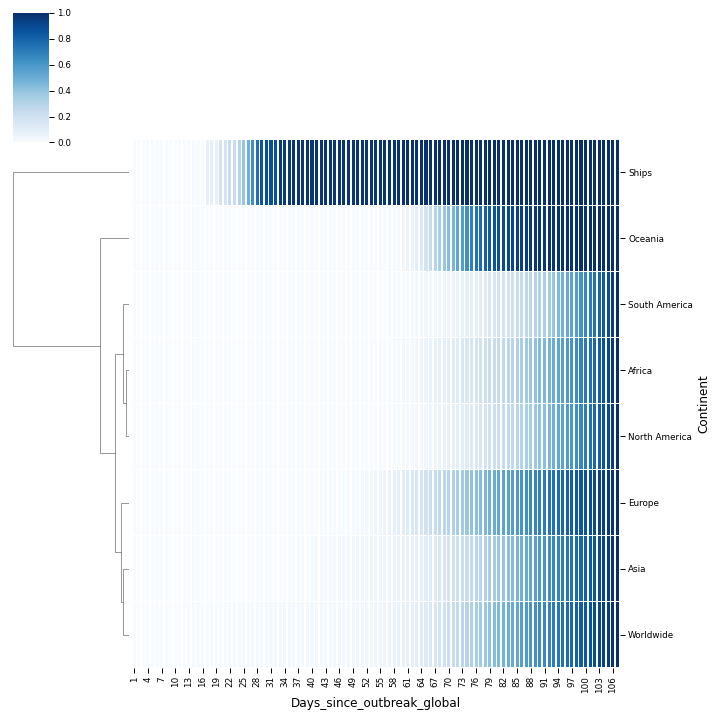

<Figure size 1800x576 with 0 Axes>

In [20]:
group_and_chart(Geography='Continent', Figure='Confirmed', Data=df)

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Afghanistan                   0    0    0    0    0    0    0    0    0    0   
Armenia                       0    0    0    0    0    0    0    0    0    0   
Azerbaijan                    0    0    0    0    0    0    0    0    0    0   
Bahrain                       0    0    0    0    0    0    0    0    0    0   
Bangladesh                    0    0    0    0    0    0    0    0    0    0   

Days_since_outbreak_global  ...   98    99    100   101   102   103    104  \
Country                     ...                                              
Afghanistan                 ...  1828  1939  2171  2335  2469  2704   2894   
Armenia                     ...  1867  1932  2066  2148  2273  2386   2507   
Azerbaijan                  ...  1717  1766  1804  1854  1894  1932   1984   
Bahrain                     ...  2811  2921  3040

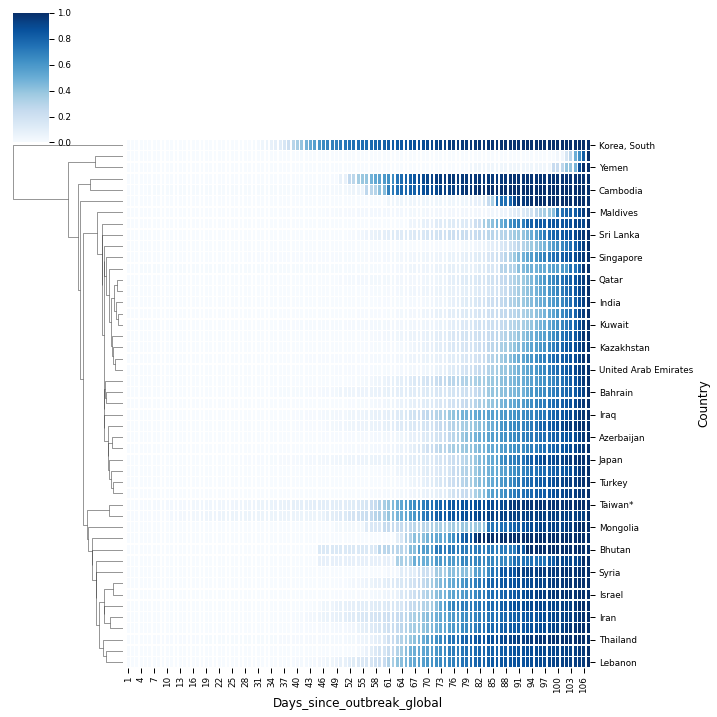

<Figure size 1800x576 with 0 Axes>

In [21]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Albania                       0    0    0    0    0    0    0    0    0    0   
Andorra                       0    0    0    0    0    0    0    0    0    0   
Austria                       0    0    0    0    0    0    0    0    0    0   
Belarus                       0    0    0    0    0    0    0    0    0    0   
Belgium                       0    0    0    0    0    0    0    0    0    0   

Days_since_outbreak_global  ...    98     99     100    101    102    103  \
Country                     ...                                             
Albania                     ...    750    766    773    782    789    795   
Andorra                     ...    743    743    745    745    747    748   
Austria                     ...  15357  15402  15452  15531  15558  15597   
Belarus                     ...  12208  13181  14027  

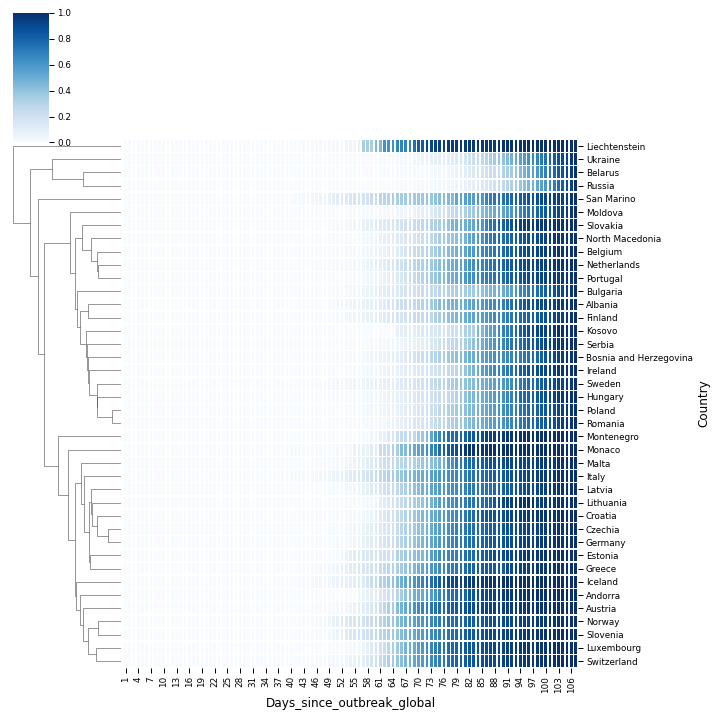

<Figure size 1800x576 with 0 Axes>

In [22]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Algeria                       0    0    0    0    0    0    0    0    0    0   
Angola                        0    0    0    0    0    0    0    0    0    0   
Benin                         0    0    0    0    0    0    0    0    0    0   
Botswana                      0    0    0    0    0    0    0    0    0    0   
Burkina Faso                  0    0    0    0    0    0    0    0    0    0   

Days_since_outbreak_global  ...   98    99    100   101   102   103   104  \
Country                     ...                                             
Algeria                     ...  3649  3848  4006  4154  4295  4474  4648   
Angola                      ...    27    27    27    30    35    35    35   
Benin                       ...    64    64    64    90    90    90    96   
Botswana                    ...    23    23    23    2

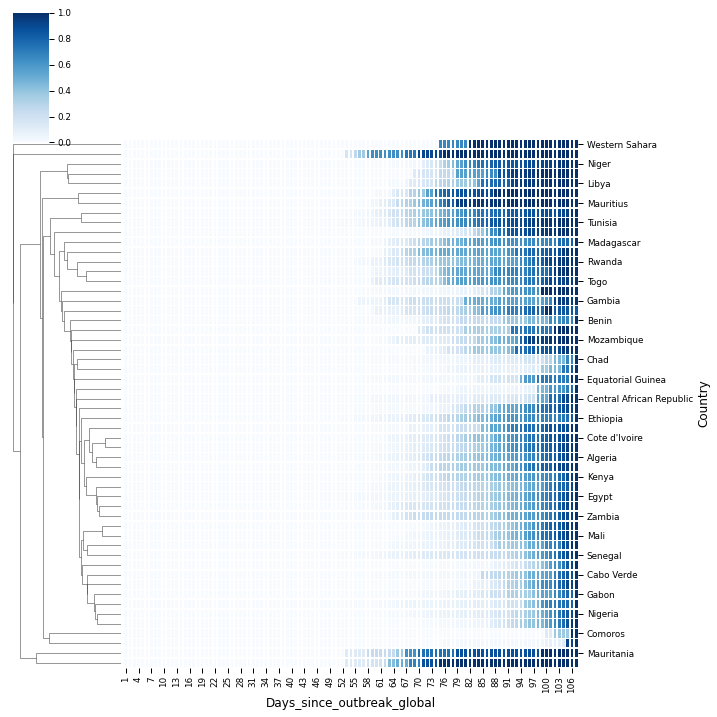

<Figure size 1800x576 with 0 Axes>

In [23]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Antigua and Barbuda           0    0    0    0    0    0    0    0    0    0   
Bahamas                       0    0    0    0    0    0    0    0    0    0   
Barbados                      0    0    0    0    0    0    0    0    0    0   
Belize                        0    0    0    0    0    0    0    0    0    0   
Costa Rica                    0    0    0    0    0    0    0    0    0    0   

Days_since_outbreak_global  ...  98   99   100  101  102  103  104  105  106  \
Country                     ...                                                
Antigua and Barbuda         ...   24   24   24   25   25   25   25   25   25   
Bahamas                     ...   80   80   81   81   83   83   83   89   92   
Barbados                    ...   80   80   81   81   81   82   82   82   82   
Belize                      ...   18   

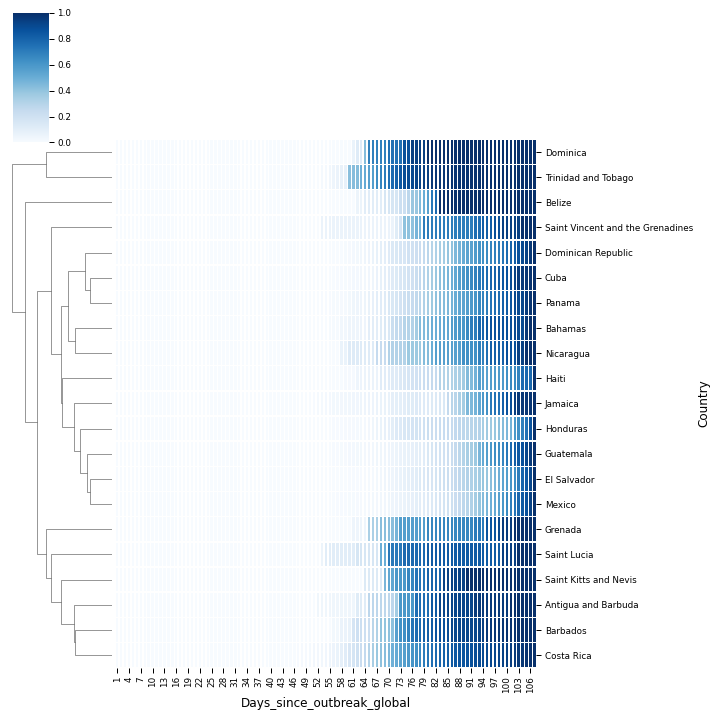

<Figure size 1800x576 with 0 Axes>

In [24]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Fiji                          0    0    0    0    0    0    0    0    0    0   
New Zealand                   0    0    0    0    0    0    0    0    0    0   
Papua New Guinea              0    0    0    0    0    0    0    0    0    0   

Days_since_outbreak_global  ...   98    99    100   101   102   103   104  \
Country                     ...                                             
Fiji                        ...    18    18    18    18    18    18    18   
New Zealand                 ...  1474  1476  1479  1485  1487  1487  1486   
Papua New Guinea            ...     8     8     8     8     8     8     8   

Days_since_outbreak_global   105   106   107  
Country                                       
Fiji                          18    18    18  
New Zealand                 1488  1489  1490  
Papua New Guinea         

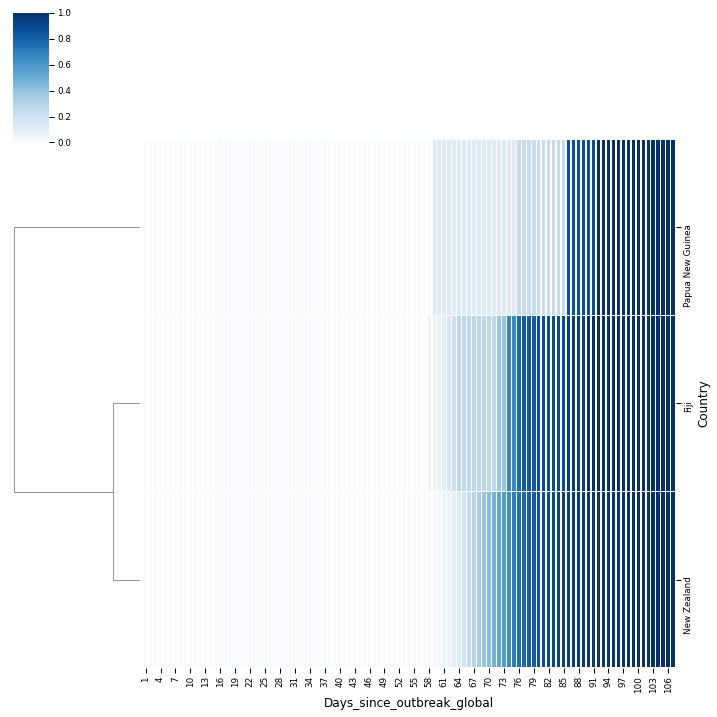

<Figure size 1800x576 with 0 Axes>

In [25]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Argentina                     0    0    0    0    0    0    0    0    0    0   
Bolivia                       0    0    0    0    0    0    0    0    0    0   
Brazil                        0    0    0    0    0    0    0    0    0    0   
Chile                         0    0    0    0    0    0    0    0    0    0   
Colombia                      0    0    0    0    0    0    0    0    0    0   

Days_since_outbreak_global  ...    98     99     100    101    102     103  \
Country                     ...                                              
Argentina                   ...   4127   4285   4428   4532   4681    4783   
Bolivia                     ...   1053   1110   1167   1229   1470    1594   
Brazil                      ...  73235  79685  87187  92202  97100  101826   
Chile                       ...  14365  14885  16

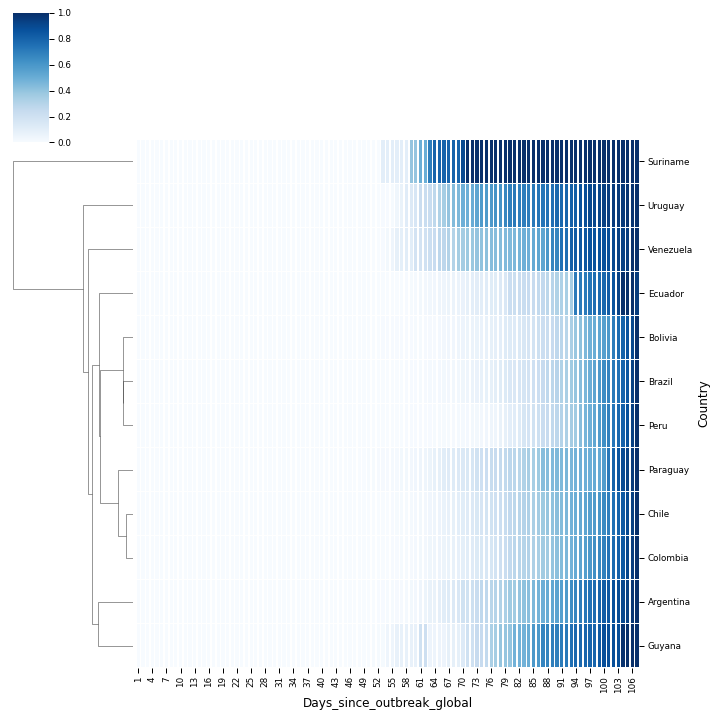

<Figure size 1800x576 with 0 Axes>

In [26]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [27]:
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = df['Confirmed']-df['Confirmed_lag_1']
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Province,Country,Lat,Long,Date,Confirmed,Province_and_country,Days_since_outbreak_global,Country_Region,iso2,Continent,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed
0,0,Afghanistan,33.00,65.00,2020-01-22,0,Afghanistan,1,Afghanistan,AF,Asia,22,2,4,1,1,2020,0.00,0.00
1,0,Albania,41.15,20.17,2020-01-22,0,Albania,1,Albania,AL,Europe,22,2,4,1,1,2020,0.00,0.00
2,0,Algeria,28.03,1.66,2020-01-22,0,Algeria,1,Algeria,DZ,Africa,22,2,4,1,1,2020,0.00,0.00
3,0,Andorra,42.51,1.52,2020-01-22,0,Andorra,1,Andorra,AD,Europe,22,2,4,1,1,2020,0.00,0.00
4,0,Angola,-11.20,17.87,2020-01-22,0,Angola,1,Angola,AO,Africa,22,2,4,1,1,2020,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28564,0,Worldwide,0.00,0.00,2020-05-03,3506729,Worldwide,103,0,0,Worldwide,3,6,18,2,5,2020,3427584.00,79145.00
28565,0,Worldwide,0.00,0.00,2020-05-04,3583055,Worldwide,104,0,0,Worldwide,4,0,19,2,5,2020,3506729.00,76326.00
28566,0,Worldwide,0.00,0.00,2020-05-05,3662691,Worldwide,105,0,0,Worldwide,5,1,19,2,5,2020,3583055.00,79636.00
28567,0,Worldwide,0.00,0.00,2020-05-06,3755341,Worldwide,106,0,0,Worldwide,6,2,19,2,5,2020,3662691.00,92650.00


In [28]:
df.to_csv('df_m.CSV',sep=',')

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    98     99     100    101    102    103  \
Country                     ...                                             
Afghanistan                 ... 125.00 111.00 232.00 164.00 134.00 235.00   
Albania                     ...  14.00  16.00   7.00   9.00   7.00   6.00   
Algeria                     ... 132.00 199.00 158.00 148.00 141.00 179.00   
Andorra                     ...   0.00   0.00   2.00  

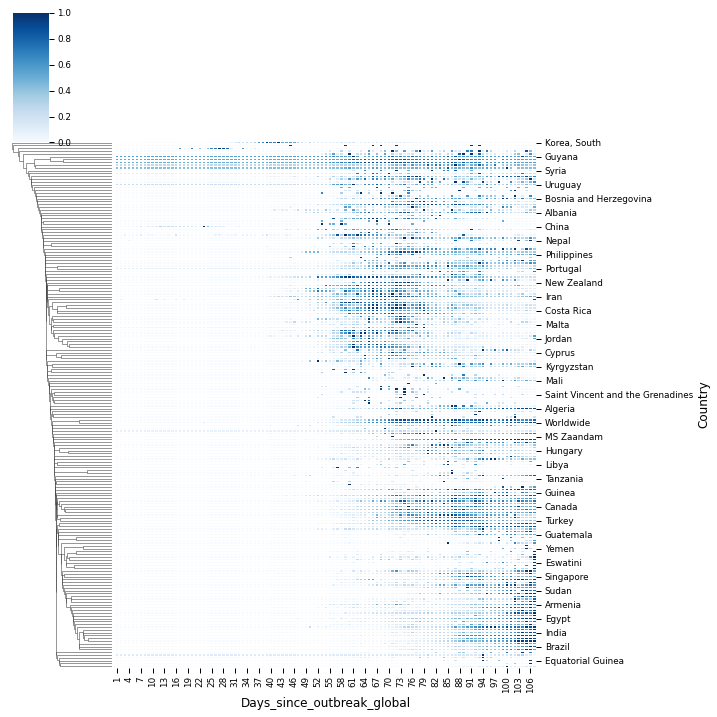

<Figure size 1800x576 with 0 Axes>

In [29]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global  1     2      3      4      5      6       7    \
Continent                                                                   
0                          0.00 95.00 280.00 487.00 677.00 803.00 2634.00   
Africa                     0.00  0.00   0.00   0.00   0.00   0.00    0.00   
Asia                       0.00  4.00   7.00   6.00   7.00   5.00   14.00   
Europe                     0.00  0.00   0.00   0.00   0.00   1.00    3.00   
North America              0.00  0.00   0.00   0.00   0.00   0.00    0.00   

Days_since_outbreak_global    8       9       10   ...      98       99   \
Continent                                          ...                     
0                          580.00 2057.00 1667.00  ... 34517.00 32936.00   
Africa                       0.00    0.00    0.00  ...  1627.00  2013.00   
Asia                         7.00   11.00   20.00  ... 10999.00 12527.00   
Europe                       1.00    0.00    6.00  ... 14515.00 15159.00   
Nort

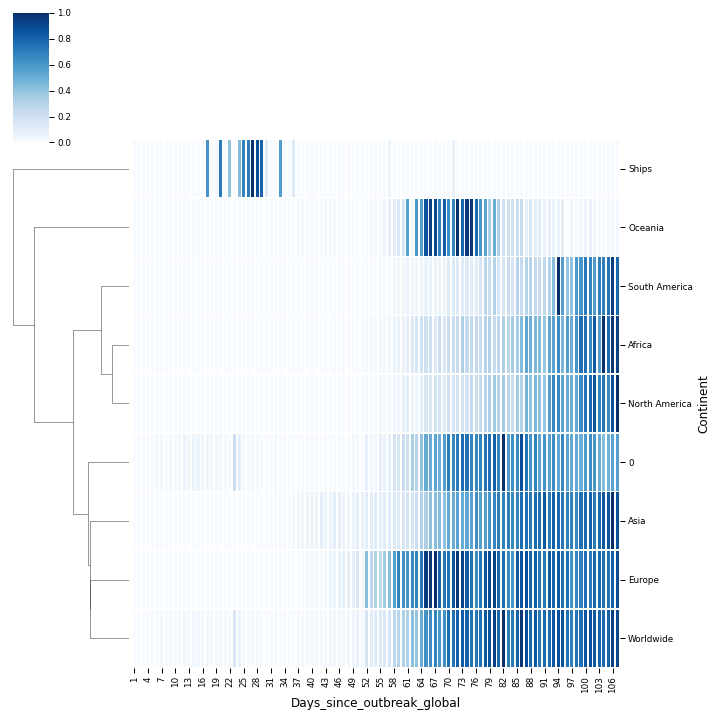

<Figure size 1800x576 with 0 Axes>

In [30]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Armenia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Azerbaijan                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahrain                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bangladesh                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    98     99     100    101    102    103  \
Country                     ...                                             
Afghanistan                 ... 125.00 111.00 232.00 164.00 134.00 235.00   
Armenia                     ...  59.00  65.00 134.00  82.00 125.00 113.00   
Azerbaijan                  ...  39.00  49.00  38.00  50.00  40.00  38.00   
Bahrain                     ...  88.00 110.00 119.00 1

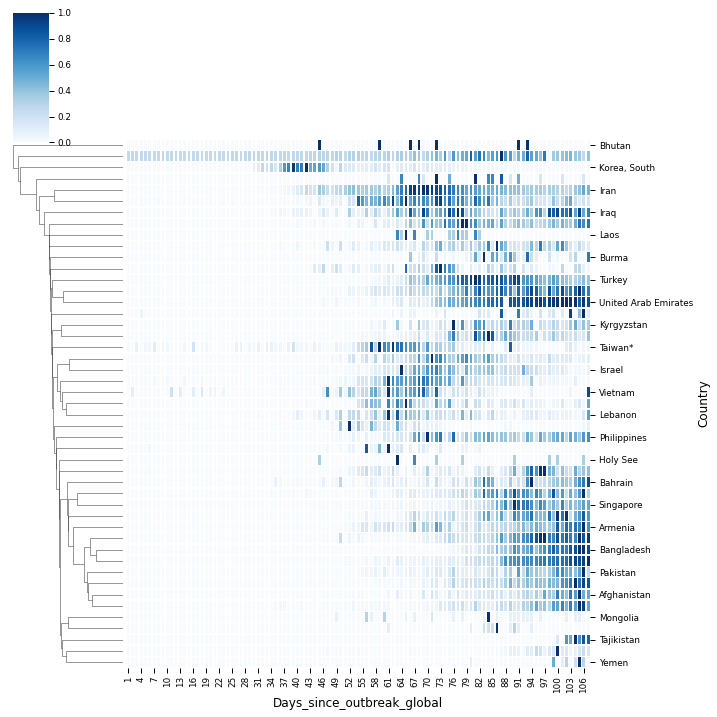

<Figure size 1800x576 with 0 Axes>

In [31]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Austria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belarus                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belgium                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    98     99     100    101    102    103  \
Country                     ...                                             
Albania                     ...  14.00  16.00   7.00   9.00   7.00   6.00   
Andorra                     ...   0.00   0.00   2.00   0.00   2.00   1.00   
Austria                     ...  83.00  45.00  50.00  79.00  27.00  39.00   
Belarus                     ... 919.00 973.00 846.00 8

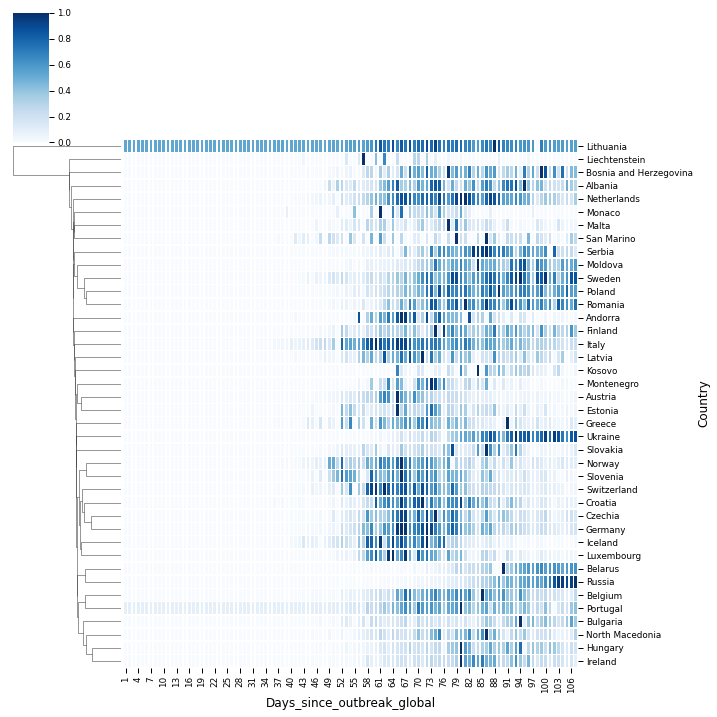

<Figure size 1800x576 with 0 Axes>

In [32]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Benin                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Botswana                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Burkina Faso               0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    98     99     100    101    102    103  \
Country                     ...                                             
Algeria                     ... 132.00 199.00 158.00 148.00 141.00 179.00   
Angola                      ...   0.00   0.00   0.00   3.00   5.00   0.00   
Benin                       ...   0.00   0.00   0.00  26.00   0.00   0.00   
Botswana                    ...   1.00   0.00   0.00  

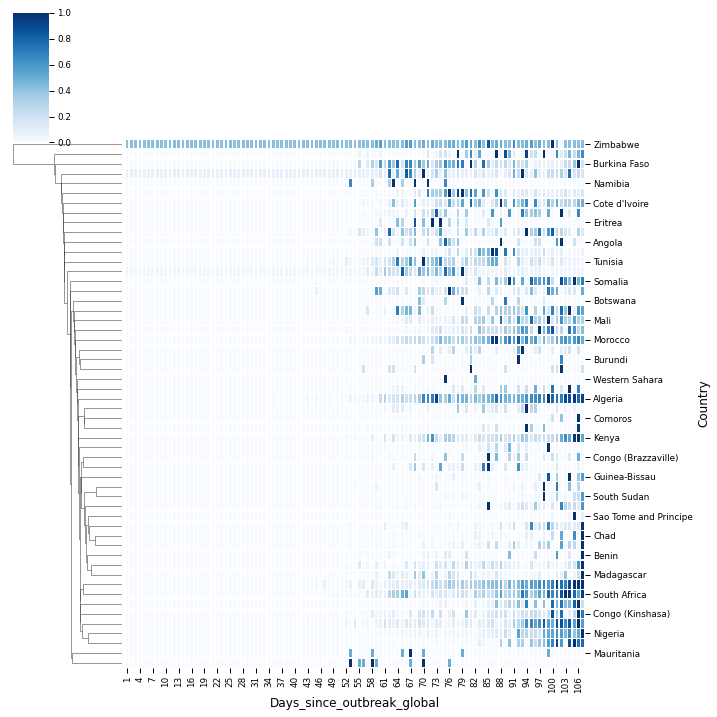

<Figure size 1800x576 with 0 Axes>

In [33]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Antigua and Barbuda        0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahamas                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Barbados                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belize                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Costa Rica                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...  98   99   100  101  102  103  104   105  106  \
Country                     ...                                                 
Antigua and Barbuda         ... 0.00 0.00 0.00 1.00 0.00 0.00 0.00  0.00 0.00   
Bahamas                     ... 0.00 0.00 1.00 0.00 2.00 0.00 0.00  6.00 3.00   
Barbados                    ... 0.00 0.00 1.00 0.00 0.00 1.00 0.00  0.00 0.00   
Belize                      ... 0.

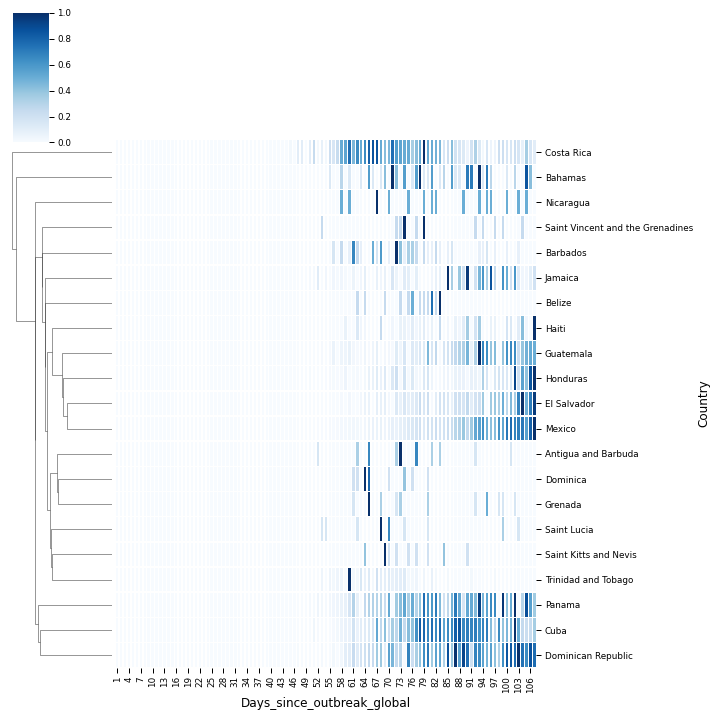

<Figure size 1800x576 with 0 Axes>

In [34]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Fiji                       0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
New Zealand                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Papua New Guinea           0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...  98   99   100  101  102  103   104  105  106  \
Country                     ...                                                 
Fiji                        ... 0.00 0.00 0.00 0.00 0.00 0.00  0.00 0.00 0.00   
New Zealand                 ... 2.00 2.00 3.00 6.00 2.00 0.00 -1.00 2.00 1.00   
Papua New Guinea            ... 0.00 0.00 0.00 0.00 0.00 0.00  0.00 0.00 0.00   

Days_since_outbreak_global  107  
Country                          
Fiji                       0.00  
New Zealand                1.00  
Papua New Guinea           0.00  

[3 rows x 107 columns]

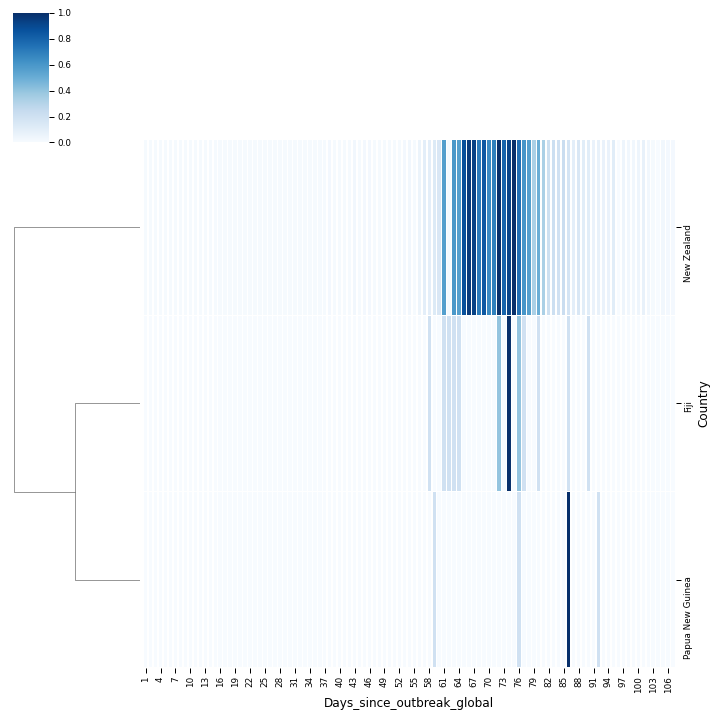

<Figure size 1800x576 with 0 Axes>

In [35]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    5    6    7    8    9    10   \
Country                                                                        
Argentina                  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bolivia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Brazil                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Chile                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Colombia                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...     98      99      100     101     102  \
Country                     ...                                           
Argentina                   ...  124.00  158.00  143.00  104.00  149.00   
Bolivia                     ...   39.00   57.00   57.00   62.00  241.00   
Brazil                      ... 5789.00 6450.00 7502.00 5015.00 4898.00   
Chile                       ...  552.00  520.00 1138.00  985.00 

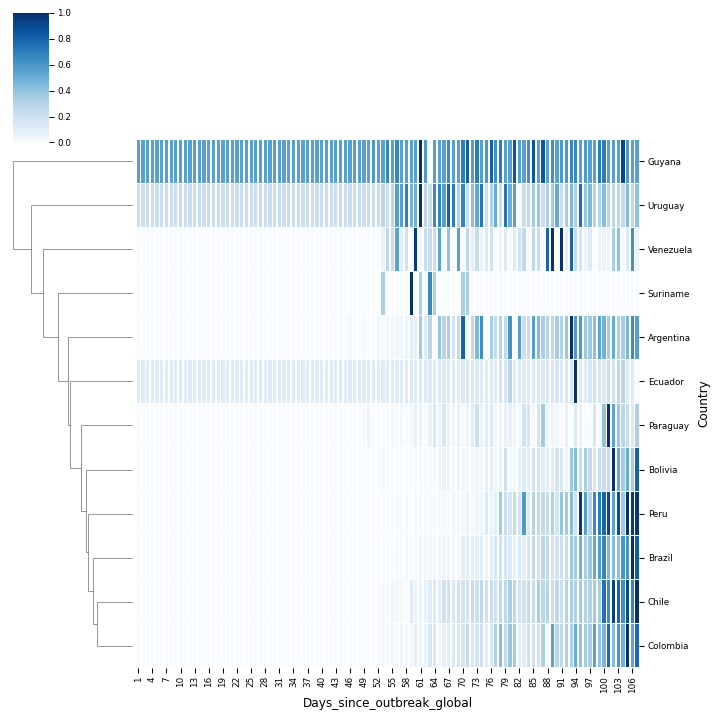

<Figure size 1800x576 with 0 Axes>

In [36]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

## Prediction

In [37]:
df_ml_confirmed = df.copy()
df_ml_confirmed['Confirmed_lag_1'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(1)
df_ml_confirmed['Confirmed'] = df_ml_confirmed['Confirmed']-df_ml_confirmed['Confirmed_lag_1']
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_ml_confirmed.Confirmed.notnull())].groupby(['Province_and_country','Lat','Long']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year','Confirmed_lag_7','Days_since_outbreak_country']]

In [38]:
df_ml_confirmed.to_csv('df_ml.CSV',sep=',')

### One Country Test

In [39]:
split_date = datetime.today() - timedelta(days=8)
split_date

datetime.datetime(2020, 4, 30, 11, 23, 59, 112273)

In [40]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

In [41]:
def root_mean_squared_log_error(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: # check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

261.56627094644
300.70623561301494
0.5471171757301885


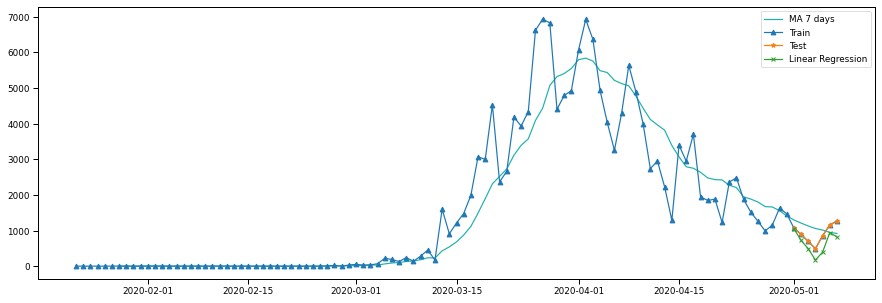

In [42]:
#Linear Regression
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class
linear_regressor.fit(X_train, y_train)

Confirmed_test['File_type'] = "Test"
Confirmed_train['File_type'] = "Train"

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
Combined = Confirmed_train.append(Confirmed_test)
Combined['MA_7_d'] = Combined['Confirmed'].rolling(window=7).mean()

plt.plot(Combined.index, Combined['MA_7_d'], label='MA 7 days', color = 'lightseagreen')
plt.plot(Combined.index, Combined['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Combined.index, Combined['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

891.1708902823375
914.4844617612899
0.7687402882907545


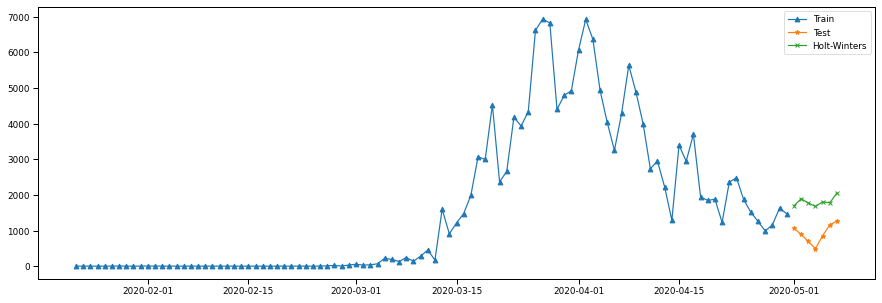

In [43]:
#Holt winters-non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

['add', True, None, 0, False, False]
563.2265188707227
616.4678429203585
0.603153127085738


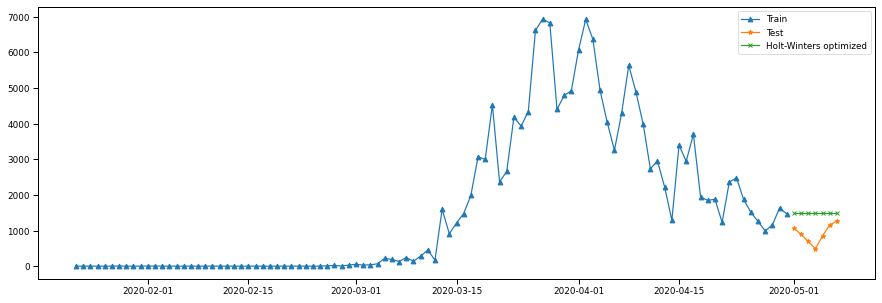

In [44]:
#Holt Winters optimized
def exp_smoothing_configs():
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = [0,6,12]
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs()

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    try:
        cg = cfg_list[j]
        t,d,s,p,b,r = cg

        model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p)

        hw_model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)

        pred = hw_model.predict(start=test.index[0], end=test.index[-1])

        pred = pd.DataFrame(pred)
        pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)
        
        rmse = np.sqrt(mean_squared_error(y_pred=pred, y_true=test))
        
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        continue

t1,d1,s1,p1,b1,r1 = best_config
print(best_config)

if t1 == None:
    model = ExponentialSmoothing(train, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    model = ExponentialSmoothing(train, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

hw_model = model.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

pred = hw_model.predict(start=test.index[0], end=test.index[-1])

pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

391.90760851049123
453.9045521479465
0.4603786744518707


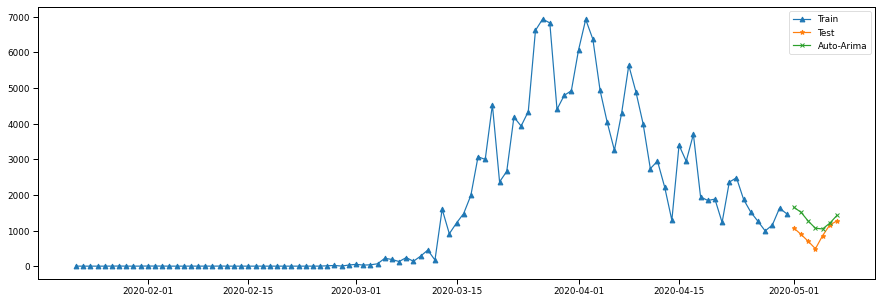

In [45]:
#Auto-Arima
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, seasonal=False, stepwise=True)  # set to stepwise

stepwise_fit.summary()

pred = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= test.index)

pred.columns = ['Confirmed']

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Auto-Arima', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

208.4494367327009
237.97582098423837
0.2963307993209469


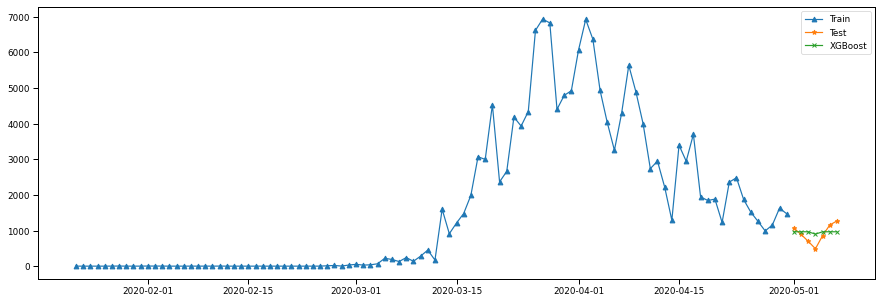

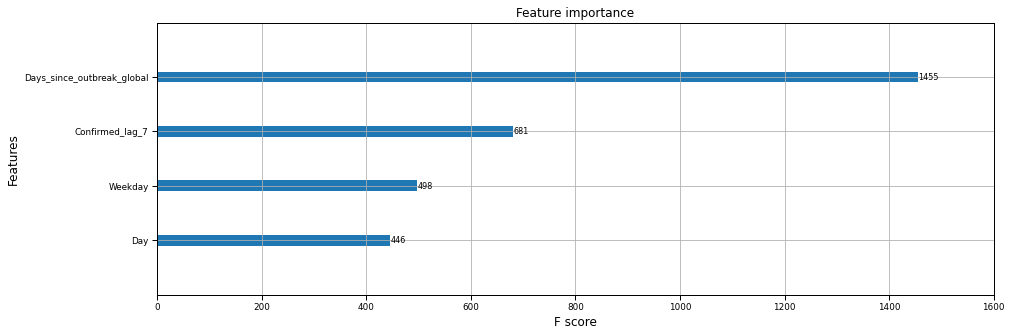

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 1000, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': None, 'validate_parameters': False, 'verbosity': None}


In [46]:
#XGBoost non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

reg = xgb.XGBRegressor(n_estimators=1000, objective= 'reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=200,
       verbose=False) # Change verbose to True if you want to see it train

Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='XGBoost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

plot_importance(reg)
pyplot.show()

print(reg.get_xgb_params())

100%|██████████████████████████████████████████████| 100/100 [00:27<00:00,  3.68trial/s, best loss: 126.33903285435268]
126.33903285435268
163.7951518074674
0.21928810406271482


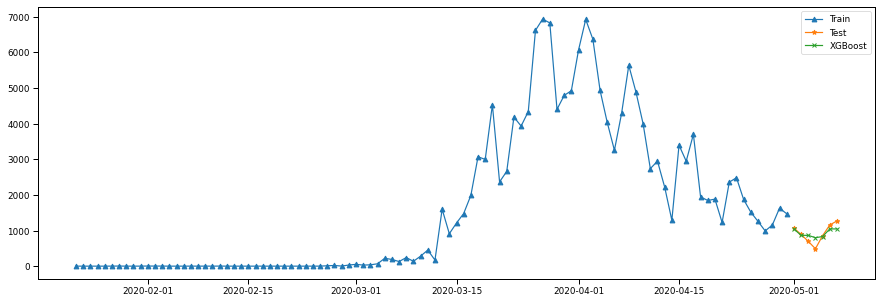

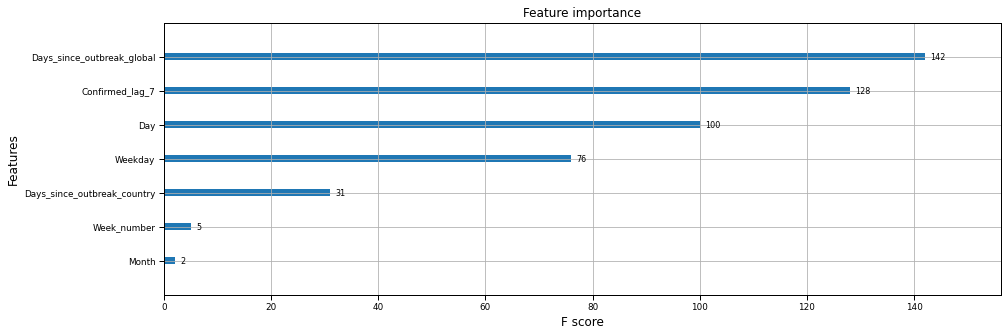

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.74318990454382, 'gamma': 2.1682466962352622, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1.0, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 1000, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 104, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': None, 'validate_parameters': False, 'verbosity': None}


In [47]:
#XGBoost Optimized
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 500,5000,500),
    }

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

def hyperparameter_tuning(space):
    reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'], objective= 'reg:squarederror')
        
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric="rmse",
            early_stopping_rounds=200,verbose=False)

    pred = reg.predict(X_test)
    mae= mean_absolute_error(y_pred=pred, y_true=y_test)
    #change the metric if you like
    clear_output(wait=True)
    return {'loss':mae, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

reg = xgb.XGBRegressor(n_estimators =int(best['n_estimators']), max_depth = int(best['max_depth']), gamma = best['gamma'],
                         reg_alpha = int(best['reg_alpha']),min_child_weight=best['min_child_weight'],
                         colsample_bytree=best['colsample_bytree'], objective= 'reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=200,
       verbose=False) # Change verbose to True if you want to see it train

Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='XGBoost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

plot_importance(reg)
pyplot.show()

print(reg.get_xgb_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

708.839462387053
751.8732745582319
0.6857764148139317


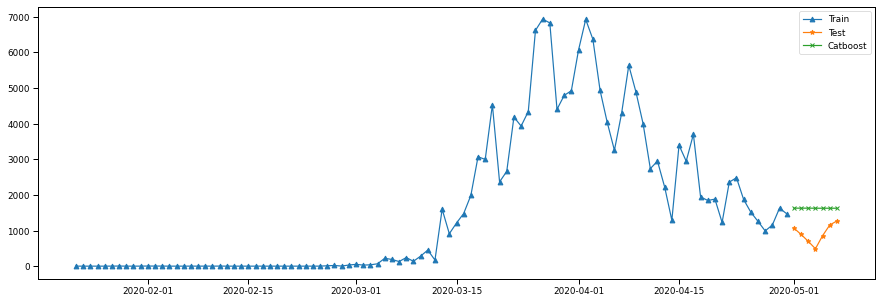

In [48]:
#Catboost non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

model = CatBoostRegressor(iterations=1000, verbose=False, loss_function='RMSE')
# Fit model
model.fit(X_train, y_train,plot=True, eval_set=(X_test, y_test))

Confirmed_test['Confirmed_Prediction'] = model.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Catboost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3131.1049639953317
3135.435338868383
1.5418451979779022


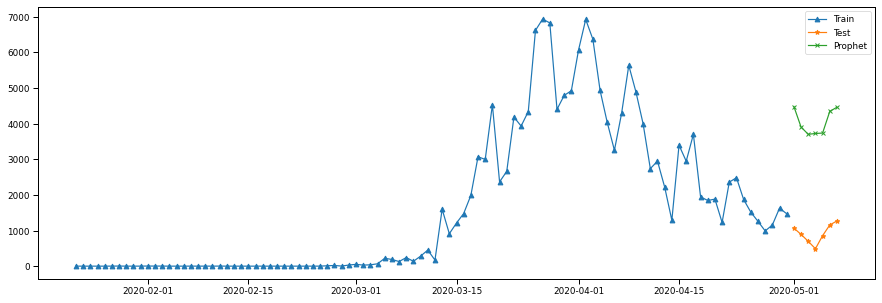

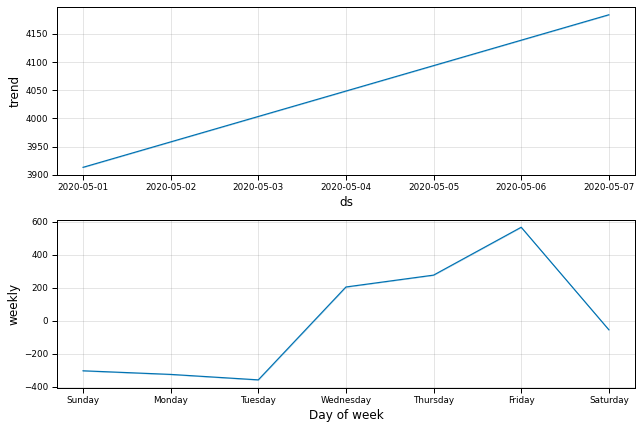

In [49]:
#Prophet
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = train[['Confirmed','Date']]
test = test[['Confirmed','Date']]

model = Prophet()
model.fit(train.reset_index().rename(columns={'Date':'ds', 'Confirmed':'y'}))

#pred = model.predict(df=test.reset_index().rename(columns={'Date':'ds'}))
pred = pd.DataFrame(model.predict(df=test.reset_index().rename(columns={'Date':'ds'})))

#pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)

test = test.reset_index(drop=True)
pred = pred.reset_index(drop=True)

plt.plot(train.Date, train.Confirmed, label='Train',marker ='^')
plt.plot(test.Date, test.Confirmed, label='Test', marker = "*")
plt.plot(test.Date, pred.yhat, label='Prophet', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred.yhat, y_true=test.Confirmed))
print(np.sqrt(mean_squared_error(y_pred=pred.yhat, y_true=test.Confirmed)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.yhat))

fig = model.plot_components(pred)

261.56627094644
300.70623561301494
0.5471171757301885


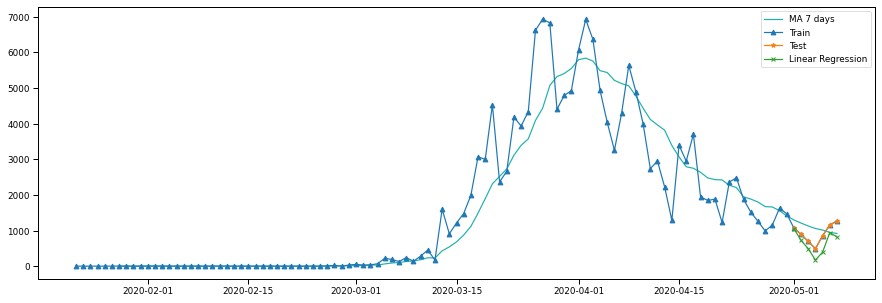

In [50]:
#Linear Regression
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class
linear_regressor.fit(X_train, y_train)

Confirmed_test['File_type'] = "Test"
Confirmed_train['File_type'] = "Train"

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
Combined = Confirmed_train.append(Confirmed_test)
Combined['MA_7_d'] = Combined['Confirmed'].rolling(window=7).mean()

plt.plot(Combined.index, Combined['MA_7_d'], label='MA 7 days', color = 'lightseagreen')
plt.plot(Combined.index, Combined['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Combined.index, Combined['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

### All customers

In [51]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
#df_ml_confirmed_var = df_ml_confirmed_var.loc[(df_ml_confirmed_var.Value == "Canada_Diamond Princess")]
#df_ml_confirmed_var = df_ml_confirmed_var.head(20)
len(df_ml_confirmed_var)

267

#### Linear Regression

In [52]:
Train_and_Test = []

In [53]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Linear = pd.concat(Train_and_Test_temp)
Train_and_Test = pd.concat(Train_and_Test_temp)


Finished!


In [54]:
Train_and_Test_Linear = Train_and_Test_Linear.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSLE.notnull(), 'RMSLE']))

143.91628148580028
169.792886895924
0.8157241300603734


#### Holt-Winters (non-optimized)

In [55]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']
    
    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(Confirmed_train_, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Non-optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt)


Finished!


In [56]:
Train_and_Test_Holt = Train_and_Test_Holt.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSLE.notnull(), 'RMSLE']))

126.88585240503467
147.64295082534895
0.7188249716058973


#### Holt-Winters (optimized)

In [57]:
def exp_smoothing_configs(i):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = [0,6,12]
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(i)

In [58]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']
    
    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    best_RMSE = np.inf
    best_config = []
    t1 = d1 = s1 = p1 = b1 = r1 = ''
    for j in range(len(cfg_list)):
        try:
            cg = cfg_list[j]
            t,d,s,p,b,r = cg

            model = ExponentialSmoothing(Confirmed_train_, trend=t, damped=d, seasonal=s, seasonal_periods=p)

            hw_model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)

            Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])

            rmse = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

            if rmse < best_RMSE:
                best_RMSE = rmse
                best_config = cfg_list[j]
        except:
            continue

    t1,d1,s1,p1,b1,r1 = best_config

    if t1 == None:
        model = ExponentialSmoothing(Confirmed_train_, trend=t1, seasonal=s1, seasonal_periods=p1)
    else:
        model = ExponentialSmoothing(Confirmed_train_, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

    hw_model = model.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt_optimized)


Finished!


In [59]:
Train_and_Test_Holt_optimized = Train_and_Test_Holt_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSLE.notnull(), 'RMSLE']))

91.55474217684706
106.94062020884293
0.5963496705008439


#### Auto-ARIMA

In [60]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    stepwise_fit = auto_arima(Confirmed_train_, error_action='ignore', trace=False,
                          suppress_warnings=True, seasonal=False, stepwise=True)  # set to stepwise

    stepwise_fit.summary()

    Confirmed_test['Confirmed_Prediction'] = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Auto-ARIMA"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_ARIMA = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_ARIMA)


Finished!


In [61]:
Train_and_Test_ARIMA = Train_and_Test_ARIMA.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSLE.notnull(), 'RMSLE']))

94.59738530420063
110.61400393791881
0.6867834639388062


#### XGboost (non-optimized)

In [62]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    reg = xgb.XGBRegressor(n_estimators=1000, objective= 'reg:squarederror')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=200,
           verbose=False) # Change verbose to True if you want to see it train

    Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = 'XGBoost (Non-optimized)'
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_XGBoost = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_XGBoost)


Finished!


In [63]:
Train_and_Test_XGBoost = Train_and_Test_XGBoost.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.RMSLE.notnull(), 'RMSLE']))

94.24146893920268
116.93154920650424
0.6374679463972832


#### XGboost (optimized)

In [64]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    def hyperparameter_tuning(space):
        reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                             reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], objective= 'reg:squarederror')

        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric="rmse",
                early_stopping_rounds=200,verbose=False)

        pred = reg.predict(X_test)
        mae= mean_absolute_error(y_pred=pred, y_true=y_test)
        #change the metric if you like
        clear_output(wait=True)
        return {'loss':mae, 'status': STATUS_OK }

    trials = Trials()
    best = fmin(fn=hyperparameter_tuning,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=trials)

    reg = xgb.XGBRegressor(n_estimators =int(best['n_estimators']), max_depth = int(best['max_depth']), gamma = best['gamma'],
                             reg_alpha = int(best['reg_alpha']),min_child_weight=best['min_child_weight'],
                             colsample_bytree=best['colsample_bytree'], objective= 'reg:squarederror')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=200,
           verbose=False) # Change verbose to True if you want to see it train

    Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = 'XGBoost (Optimized)'
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_XGBoost_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_XGBoost_optimized)


100%|██████████████████████████████████████████████| 100/100 [00:18<00:00,  5.54trial/s, best loss: 3973.6417410714284]

Finished!


In [65]:
Train_and_Test_XGBoost_optimized = Train_and_Test_XGBoost_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.RMSLE.notnull(), 'RMSLE']))

77.01936193286511
98.19959490625305
0.6065048426294289


#### CatBoost

In [66]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    try:
    
        List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]

        Confirmed_train = List.loc[List.Date <= split_date].copy()
        Confirmed_test = List.loc[List.Date > split_date].copy()

        X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
        X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)

        model = CatBoostRegressor(iterations=1000, verbose=False)
        model.fit(X_train, y_train)

        Confirmed_test['Confirmed_Prediction'] = model.predict(X_test)

        Confirmed_test['File_type'] = "Test"
        Confirmed_train['File_type'] = "Train"

        Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)

        Train_and_Test_['Model'] = 'CatBoost'

        Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

        Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

        Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])

        Train_and_Test_temp.append(Train_and_Test_)
        
    except Exception as e: 
        pass
    
print("Finished!")

Train_and_Test_CatBoost = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_CatBoost)


Finished!


In [67]:
Train_and_Test_CatBoost = Train_and_Test_CatBoost.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.RMSLE.notnull(), 'RMSLE']))

164.5933902083999
185.88226527268756
0.9394026313473938


#### Prophet

In [ ]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)
    
    Confirmed_train_ = Confirmed_train[['Confirmed','Date']]
    Confirmed_test_ = Confirmed_test[['Confirmed','Date']]

    model = Prophet()
    model.fit(Confirmed_train_.reset_index(drop=True).rename(columns={'Date':'ds', 'Confirmed':'y'}))

    Confirmed_pred = model.predict(df=Confirmed_test_.reset_index(drop=True).rename(columns={'Date':'ds'}))
    
    Confirmed_test.index.name = None
    Confirmed_test = pd.merge(Confirmed_test, Confirmed_pred[['ds','yhat']], left_on='Date', right_on='ds', how='left').rename(columns={'yhat':'Confirmed_Prediction'}).drop(columns=['ds'])
            
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Prophet"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Prophet = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Prophet)

In [69]:
Train_and_Test_Prophet = Train_and_Test_Prophet.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.RMSLE.notnull(), 'RMSLE']))

221.9325305642461
238.43185031164288
0.9247340096792697


#### Final Steps

In [70]:
Train_and_Test['Update_date'] = datetime.today()

In [71]:
Train_and_Test.to_csv('Train_and_Test.CSV',sep=',')

In [72]:
Train_and_Test.to_excel('C:/Users/xxx/Google Drive/Train_and_Test.xlsx', index = False)

In [103]:
#Set the variables for the scraper
headers = {"Accept-Language": "en-US, en;q=0.5"}

#specify the url
urlpage = 'https://public.tableau.com/profile/armin.kr.nke#!/vizhome/COVID19MachineLearningmethodsprediction/Dashboard' 
print(urlpage)

#run Chrome webdriver from executable path of your choice
options = webdriver.ChromeOptions()
options.add_argument(r'user-data-dir=C:\Users\xxx\AppData\Local\Google\Chrome\User Data')
options.add_argument('--profile-directory=Default')
options.add_argument('--start-maximized')
browser = webdriver.Chrome(executable_path=r"C:\Users\xxx\Downloads\chromedriver.exe", chrome_options=options)

#get web page
browser.get(urlpage)
browser.execute_script("window.scrollTo(0, document.body.scrollHeight)")
sleep(10)
browser.find_element_by_xpath("/html/body/div[1]/div[2]/section/div/div[2]/section[3]/div/figcaption/div[2]/div/div/div[2]/dl/div[1]/dd/button").click()
sleep(120)
browser.close()

https://public.tableau.com/profile/armin.kr.nke#!/vizhome/COVID19MachineLearningmethodsprediction/Dashboard
